# Supervised Learning - Machine Learning 2020
## Dengue
### Group AA



##  Libraries and tools

Import the libraries and tools needed to carry out our tasks

In [ ]:
# Data load and manipulation
from google.colab import files
import io
from datetime import datetime

# DataFrame librery
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tabulate import tabulate

# Basic Operations
import numpy as np
from numpy import corrcoef, transpose
import itertools
from math import pi, sin, cos
from scipy.stats import randint as sp_randint

# Prepocessing
from sklearn import preprocessing 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Models
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.metrics import mean_absolute_error

## Data loading

We define a method to perform the data load

In [ ]:
def upload_files (index_fields):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    return df

Load training dataset features (dengue_features_train)

In [ ]:
print("Please, upload 'dengue_features_train' file")
X_train = upload_files(['city', 'weekofyear', 'year'])
X_train.head()

Please, upload 'dengue_features_train' file


Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


week_start_date  ...  station_precip_mm
city weekofyear year                  ...                   
sj   18         1990      1990-04-30  ...               16.0
     19         1990      1990-05-07  ...                8.6
     20         1990      1990-05-14  ...               41.4
     21         1990      1990-05-21  ...                4.0
     22         1990      1990-05-28  ...                5.8

[5 rows x 21 columns]

Load training dataset labels (dengue_labels_train)

In [ ]:
print("Please, upload 'dengue_labels_train' file")
y_train = upload_files(['city', 'weekofyear', 'year'])
y_train.head()

Please, upload 'dengue_labels_train' file


Saving dengue_labels_train.csv to dengue_labels_train.csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes


total_cases
city weekofyear year             
sj   18         1990            4
     19         1990            5
     20         1990            4
     21         1990            3
     22         1990            6

Load training dataset features (dengue_features_test)

In [ ]:
print("Please, upload 'dengue_features_test' file")
X_test = upload_files(['city', 'weekofyear', 'year'])
X_test.head()

Please, upload 'dengue_features_test' file


Saving dengue_features_test.csv to dengue_features_test.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


week_start_date  ...  station_precip_mm
city weekofyear year                  ...                   
sj   18         2008      2008-04-29  ...               75.2
     19         2008      2008-05-06  ...               34.3
     20         2008      2008-05-13  ...                3.0
     21         2008      2008-05-20  ...                0.3
     22         2008      2008-05-27  ...               84.1

[5 rows x 21 columns]

# Feature addition

As we can see in the next visualization, our data has a high time related component. This component, can help us in our labor of predicting, so we have to find out how to represent it in our data.

In [ ]:
X_train["week_start_date"] = X_train["week_start_date"].apply(lambda k: datetime.strptime(k, "%Y-%m-%d"))

df_to_plot = X_train.copy()

df_to_plot["target"] = y_train["total_cases"]
df_to_plot["city"] = "Iquitos"
df_to_plot.loc["sj", "city"] = "San Juan"

fig = px.line(df_to_plot, x="week_start_date", y="target", color = "city")
fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning:

indexing past lexsort depth may impact performance.



To represent this temporal component, we are going to extract various time component like weekday, month or season. Then we'll apply some transformations to add numeric periodic features using this time components.

In [ ]:
def get_season(x):
    year = str(x.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if x in seasons['spring']:
        return 1 # Spring
    if x in seasons['summer']:
        return 2 # Summer
    if x in seasons['autumn']:
        return 3 # Autumn
    else:
        return 4 # Winter


X_train["week_start_date"] = pd.to_datetime(X_train["week_start_date"])
X_train["month"] = X_train["week_start_date"].dt.month
X_train["season"] = X_train["week_start_date"].apply(lambda x: get_season(x))

X_train["month_cos"] = X_train.apply(lambda x: cos( ((x['month']-5)%12) / (12.0 * 2 * pi)), axis=1)
X_train["month_sin"] = X_train.apply(lambda x: sin( ((x['month']-5)%12) / (12.0 * 2 * pi)), axis=1)
X_train["season_cos"] = X_train.apply(lambda x: cos( ((x['season']-3)%4) / (4.0 * 2 * pi)), axis=1)
X_train["season_sin"] = X_train.apply(lambda x: sin( ((x['season']-3)%4) / (4.0 * 2 * pi)), axis=1)

## Preprocessing & Transformation


First we are going to drop useless features.

In [ ]:
X_train.drop("week_start_date", axis = 1, inplace = True)
X_train.drop("month", axis = 1, inplace = True)
X_train.drop("season", axis = 1, inplace = True)

As we saw in the base line notebook, we have many null values. We use the K Nearest Neighbour Imputer to fill those empty values.

In [ ]:
imputer = KNNImputer(n_neighbors=3)
X_train[:] = imputer.fit_transform(X_train)

pd.isnull(X_train).any()

ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_precip_mm                        False
month_cos                                False
month_sin    

Normalize data using an scaler. We have tested several scalers, concluding that the MinMaxScaler was the one that gave us better results. 

Tested scalers:
- MinMaxScaler
- StandardScaler
- RobustScaler
- ...

In [ ]:
# Define the scaler
scaler = MinMaxScaler()

# Fit & transform over train data
X_train = pd.DataFrame(data = scaler.fit_transform(X_train), columns=X_train.columns)
X_train.shape

(1456, 24)

Remove index from the labels in order to easily handle data.

In [ ]:
y_train.reset_index(drop=True, inplace=True)

Reshape 

In [ ]:
y_train = y_train.to_numpy()
y_train = np.reshape(y_train, (len(y_train)))
y_train.shape

(1456,)

## Feature Selection


In order to identify those features that are redundant and therefore do not contribute to the model, we will compute the correlation matrix between the different features that we can find in our training dataset.

First, we compute the transposed dataset for our training dataset.

In [ ]:
transposed_df = transpose(X_train)
names = transposed_df.index.values
transposed_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455
ndvi_ne,0.578226,0.629943,0.479441,0.584823,0.658698,0.618738,0.567621,0.523449,0.556195,0.618738,0.655063,0.763005,0.608804,0.618738,0.561493,0.618738,0.652174,0.720692,0.701558,0.584094,0.658862,0.571120,0.694069,0.631309,0.561493,0.604030,0.719981,0.611027,0.762131,0.741794,0.593716,0.564231,0.576860,0.764682,0.774923,0.604358,0.618738,0.618738,0.806412,0.544441,...,0.765973,0.669741,0.698137,0.769362,0.768691,0.762084,0.869140,0.847491,0.889234,0.811676,0.825249,0.654325,0.682096,0.674248,0.651737,0.580382,0.603030,0.719833,0.732032,0.630161,0.696482,0.764864,0.776188,0.583384,0.785013,0.766285,0.735327,0.598818,0.709696,0.616588,0.697278,0.706306,0.729345,0.628615,0.731813,0.818931,0.619290,0.714304,0.809270,0.770206
ndvi_nw,0.614835,0.657063,0.690881,0.770066,0.788882,0.692949,0.602837,0.580542,0.661456,0.634412,0.591360,0.733530,0.689490,0.772354,0.571573,0.641532,0.686305,0.864168,0.720598,0.980969,0.701278,0.787455,0.709313,0.575105,0.578016,0.599487,0.702376,0.700555,0.747588,0.863729,0.738719,0.598224,0.788289,0.794008,0.805393,0.655187,0.611257,0.823331,0.840647,0.771557,...,0.798186,0.781257,0.800195,0.810816,0.839716,0.762250,0.910369,0.918211,0.868946,0.816961,0.819853,0.713463,0.764830,0.783322,0.696592,0.697648,0.657216,0.754052,0.754177,0.656999,0.708772,0.773099,0.786529,0.699879,0.822364,0.776550,0.831751,0.725764,0.800477,0.672922,0.824560,0.785666,0.781838,0.674993,0.800195,0.851154,0.677048,0.661327,0.770839,0.756782
ndvi_se,0.386418,0.321190,0.311879,0.438912,0.481601,0.487224,0.398313,0.301536,0.254772,0.318168,0.374609,0.571878,0.437726,0.713614,0.324956,0.401718,0.330760,0.505021,0.540492,0.250851,0.488152,0.388150,0.411700,0.352082,0.355964,0.260653,0.602211,0.350028,0.353742,0.265717,0.347242,0.509737,0.373603,0.499037,0.337277,0.301587,0.482864,0.497386,0.427125,0.468343,...,0.573451,0.533523,0.518382,0.490138,0.682197,0.601644,0.479253,0.714207,0.689781,0.615676,0.769431,0.461172,0.356244,0.427314,0.427279,0.323873,0.272337,0.366278,0.423230,0.240946,0.323228,0.401125,0.435172,0.245555,0.520214,0.536257,0.562489,0.481188,0.393257,0.360293,0.626870,0.583769,0.493466,0.268313,0.494368,0.490886,0.273679,0.480079,0.531588,0.523154
ndvi_sw,0.395544,0.359233,0.384430,0.491150,0.509943,0.402314,0.449123,0.322386,0.306916,0.436481,0.355037,0.564624,0.456155,0.729833,0.331949,0.380164,0.386797,0.570609,0.482219,0.347415,0.605675,0.504819,0.434215,0.362893,0.376074,0.307455,0.589619,0.410331,0.489509,0.309842,0.336426,0.517097,0.448654,0.600823,0.369301,0.378640,0.329914,0.461639,0.436794,0.425050,...,0.520894,0.443193,0.572367,0.628809,0.697510,0.533341,0.716145,0.871876,0.742948,0.690854,0.711949,0.573188,0.534489,0.596765,0.390065,0.326394,0.378992,0.600916,0.532825,0.332746,0.496048,0.541662,0.651007,0.338364,0.751890,0.664672,0.589361,0.342427,0.530903,0.327074,0.505120,0.609378,0.662445,0.343012,0.505284,0.584064,0.474367,0.487587,0.638162,0.622199
precipitation_amt_mm,0.031797,0.058423,0.088428,0.039324,0.019252,0.024526,0.008909,0.386892,0.049462,0.036892,0.057015,0.151485,0.042192,0.083615,0.073733,0.232335,0.082949,0.104813,0.073886,0.165284,0.367972,0.131567,0.079826,0.131644,0.367512,0.325218,0.259473,0.052381,0.051203,0.051306,0.086047,0.025499,0.000000,0.134281,0.000000,0.000000,0.040579,0.000000,0.000000,0.000000,...,0.201434,0.146390,0.052688,0.078059,0.211444,0.198105,0.117230,0.246365,0.076088,0.097721,0.188044,0.219201,0.207911,0.252919,0.013526,0.069227,0.084460,0.048746,0.354608,0.121121,0.200333,0.082412,0.216769,0.206298,0.147926,0.310292,0.131311,0.127496,0.240041,0.044368,0.221966,0.066564,0.189375,0.152074,0.002944,0.141577,0.221377,0.150896,0.152765,0.161854


We calculate the correlation matrix and show a heat map showing such correlation between features.

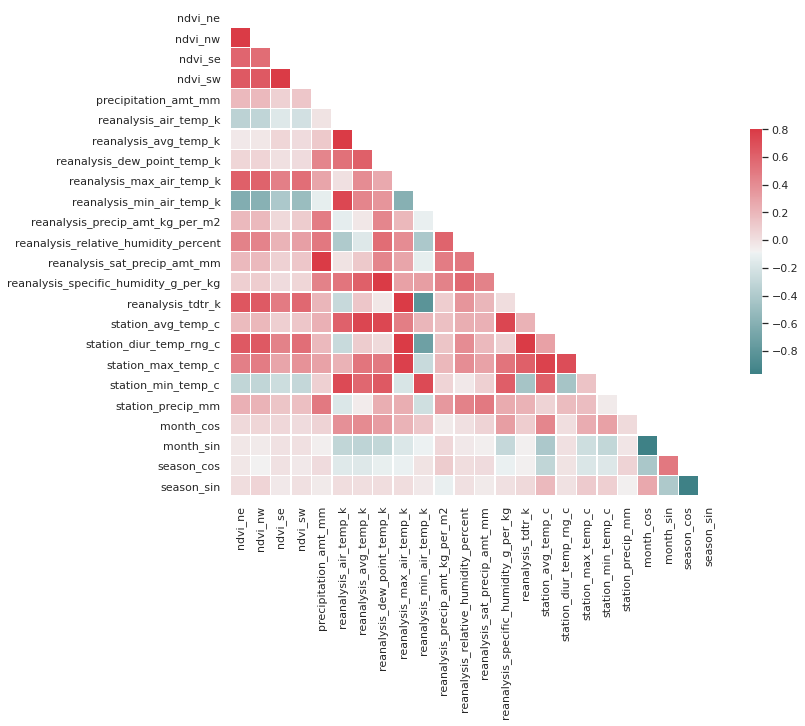

In [ ]:
R = corrcoef(transposed_df)

# Generate a mask for the upper triangle
sns.set(style="white")
mask = np.zeros_like(R, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(R, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names, yticklabels=names,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Some features are correlated between them (nvdi_xx features for example) but they are not correlated enought to conclude that they are redundant. We will continue the feature selection being conscious of this correlations.

After this first impression, lets use a class from scikit learn for feature selection. We'll use the SelectPercentile Class, which allow us to select features according to a percentile of the highest scores. 

We used 'f_regression' as score function, which compute F-value between label/feature for regression tasks.

In [ ]:
X_train.shape

(1456, 24)

In [ ]:
feature_selector = SelectPercentile(f_regression, percentile=80)
New_X_train = feature_selector.fit_transform(X_train, y_train)
New_X_train.shape

(1456, 19)

In [ ]:
features_names = np.asarray(X_train.columns)[feature_selector.get_support()]
features_names

array(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c',
       'station_min_temp_c', 'station_precip_mm', 'month_cos',
       'season_cos', 'season_sin'], dtype=object)

As we can see, in this new features we have every ndvi_xx features, which had a strong correlation between them, so we are going to drop 3 of this features in order to reduce even more this features.

In [ ]:
features_names = np.delete(features_names, [0, 2, 3])
features_names

array(['ndvi_nw', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c',
       'station_min_temp_c', 'station_precip_mm', 'month_cos',
       'season_cos', 'season_sin'], dtype=object)

Lets see the new X for train.

In [ ]:
New_X_train = X_train[features_names]
New_X_train = New_X_train.to_numpy()
New_X_train

array([[0.61483516, 0.38829084, 0.35466667, ..., 0.        , 0.55526223,
        0.66754738],
       [0.65706338, 0.4727101 , 0.44177778, ..., 1.        , 0.55526223,
        0.66754738],
       [0.69088077, 0.54806421, 0.496     , ..., 1.        , 0.55526223,
        0.66754738],
       ...,
       [0.66132695, 0.25949009, 0.336     , ..., 0.99172098, 0.55526223,
        0.66754738],
       [0.77083949, 0.22606232, 0.32711111, ..., 0.99172098, 0.55526223,
        0.66754738],
       [0.75678172, 0.45760151, 0.61511111, ..., 0.99172098, 0.        ,
        1.        ]])

## Random Forest Models with GridSearch Optimization

First, we'll choose a model that will be our regressor. 

In [ ]:
model = RandomForestRegressor() 
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Then, we define a function to report best results of GridSearch Hyperparameter optimization.

In [ ]:
# Show the N best models(Specified in 'n_top' parameter) given results of Gridsearch Hyperparameter Optimization
def report(results, n_top=3): 
    # Iterate over range between 1 and n_top + 1
    for i in range(1, n_top + 1):
        # Get N-best models in results
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        # For each candidate, show rank, scores and parameters
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


We'll use the Grid Search aproach for hyperparameter optimization. This aproach allow us to methodically construct and evaluate a model for each combination of specified algorithm parameters in a grid.

First of all, we need to define the set of parameters to be used in the GridSearch.

In [ ]:
param_dict = {"n_estimators": [16, 32, 64, 128, 256, 512, 1024, 2048],          # Number of trees in random forest
              "criterion": ['mse'],                                      # Function to measure the quality of a split
              "max_depth": [2, 4, 8, 12, 16, None],                             # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50),                           # Minimum number of samples required to split a node
              "min_samples_leaf": sp_randint(1, 50),                            # Minimum number of samples required at each leaf node
              "max_features": ['auto', 'sqrt', 'log2'],                         # Number of features to consider at every split
              "bootstrap": [True, False],                                       # Method of selecting samples for training each tree
            }

Define the cross validater we'll use in GridSearch Hyperparameter Optimization

In [ ]:
cross_validator = TimeSeriesSplit(n_splits = 4)


Then, we run the search.

In [ ]:
rand_search = RandomizedSearchCV(estimator = model, param_distributions = param_dict, n_iter = 250, cv = cross_validator, verbose = 4, random_state=0, n_jobs = -1)

# Fit the random search model
rand_search.fit(X = New_X_train, y = y_train)

Fitting 4 folds for each of 250 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Show the N best models on GridSearch results

In [ ]:
#@title Number of models to get from Grid Search results
N_best_models = 10 #@param {type:"slider", min:1, max:15, step:1}

report(rand_search.cv_results_, n_top = N_best_models)

Model with rank: 1
Mean validation score: -0.968 (std: 1.363)
Parameters: {'bootstrap': False, 'criterion': 'mse', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 28, 'n_estimators': 16}

Model with rank: 2
Mean validation score: -1.091 (std: 1.385)
Parameters: {'bootstrap': False, 'criterion': 'mse', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 20, 'min_samples_split': 28, 'n_estimators': 1024}

Model with rank: 3
Mean validation score: -1.126 (std: 1.417)
Parameters: {'bootstrap': False, 'criterion': 'mse', 'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 18, 'min_samples_split': 5, 'n_estimators': 512}

Model with rank: 4
Mean validation score: -1.157 (std: 1.643)
Parameters: {'bootstrap': False, 'criterion': 'mse', 'max_depth': 16, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 25, 'n_estimators': 16}

Model with rank: 5
Mean validation score: -1.168 (std: 1.545)
Parameters: {'bootstrap': False, '

Obtain the best model

In [ ]:
# Select the best model
best_model = rand_search.best_estimator_

#Our best model, to test remove next '#'
#best_model = RandomForestRegressor(n_estimators=16, criterion='mse', max_depth=12, min_samples_split=28, min_samples_leaf=8, max_features='sqrt', bootstrap=False)

# Fit the model
best_model.fit(X = New_X_train, y = y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=28, min_weight_fraction_leaf=0.0,
                      n_estimators=16, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# Predict & export results

First, lets add the same features we did before on the training data.

In [ ]:
X_test["week_start_date"] = pd.to_datetime(X_test["week_start_date"])
X_test["month"] = X_test["week_start_date"].dt.month
X_test["season"] = X_test["week_start_date"].apply(lambda x: get_season(x))

X_test["month_cos"] = X_test.apply(lambda x: cos( ((x['month']-5)%12) / (12.0 * 2 * pi)), axis=1)
X_test["month_sin"] = X_test.apply(lambda x: sin( ((x['month']-5)%12) / (12.0 * 2 * pi)), axis=1)
X_test["season_cos"] = X_test.apply(lambda x: cos( ((x['season']-3)%4) / (4.0 * 2 * pi)), axis=1)
X_test["season_sin"] = X_test.apply(lambda x: sin( ((x['season']-3)%4) / (4.0 * 2 * pi)), axis=1)

Our test data has null values, so first of all, we have to fill such values. For this porpuse, we'll use the imputer used previously for training data.

In [ ]:
# Drop useless features
X_test = X_test.drop("week_start_date", axis = 1)
X_test = X_test.drop("month", axis = 1)
X_test = X_test.drop("season", axis = 1)

In [ ]:
# Remove null values
X_test[:] = imputer.transform(X_test)
pd.isnull(X_test).any()

ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_precip_mm                        False
month_cos                                False
month_sin    

Then, we normalize data using the scaler previously fit on training data.

In [ ]:
# Save index from test data
test_index = X_test.index

# Use scaler over test data
New_X_test = pd.DataFrame(data = scaler.transform(X_test), columns=X_test.columns)

# Select features like we did over training data
New_X_test = New_X_test[features_names]
New_X_test.head()

,ndvi_nw,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_min_temp_c,station_precip_mm,month_cos,season_cos,season_sin
0,0.480161,0.509915,0.455111,0.554582,0.203704,0.730769,0.514278,0.480562,0.120740,0.545593,0.224335,0.642202,0.138413,0.0,0.555262,0.667547
1,0.487299,0.507649,0.456000,0.539659,0.185185,0.753846,0.500770,0.466024,0.082765,0.496960,0.091255,0.688073,0.063133,1.0,0.555262,0.667547
2,0.635401,0.637205,0.555556,0.643309,0.271605,0.730769,0.501750,0.566972,0.209348,0.694529,0.288973,0.743119,0.005522,1.0,0.555262,0.667547
3,0.479099,0.668178,0.601778,0.540470,0.320988,0.769231,0.373040,0.464227,0.203505,0.708207,0.154626,0.889908,0.000552,1.0,0.555262,0.667547
4,0.544665,0.680076,0.594667,0.581022,0.277778,0.800000,0.399216,0.505554,0.148978,0.661094,0.226869,0.788991,0.154795,1.0,0.555262,0.667547


In [ ]:
# Predict over the test data
y_pred = best_model.predict(X = New_X_test)

# Round the result and cast to integer
y = np.rint(y_pred)
y = y.astype(int)
res = np.hstack(y)

# Generate output
output = pd.DataFrame({ 'city': test_index.get_level_values(0), 'year': test_index.get_level_values(2), 'weekofyear': test_index.get_level_values(1), 
                       'total_cases': res})

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  
files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>